In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
train_df = pd.read_csv('./train.csv', index_col='id')
test_df = pd.read_csv('./test.csv', index_col='id')

In [3]:
train_df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [4]:
name_dic = dict(
    zip(train_df.columns,
       [
           'productId',
           'type',
           'airTemp',
           'processTemp',
           'rotationalSpeed',
           'torque',
           'toolWear',
           'target',
           'twf',
           'hdf',
           'pwf',
           'osf',
           'rnf'
       ])
)

In [5]:
train_df.rename(columns=name_dic, inplace=True)

# EDA

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   productId        136429 non-null  object 
 1   type             136429 non-null  object 
 2   airTemp          136429 non-null  float64
 3   processTemp      136429 non-null  float64
 4   rotationalSpeed  136429 non-null  int64  
 5   torque           136429 non-null  float64
 6   toolWear         136429 non-null  int64  
 7   target           136429 non-null  int64  
 8   twf              136429 non-null  int64  
 9   hdf              136429 non-null  int64  
 10  pwf              136429 non-null  int64  
 11  osf              136429 non-null  int64  
 12  rnf              136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.6+ MB


In [7]:
train_df.shape

(136429, 13)

array([[<Axes: title={'center': 'airTemp'}>,
        <Axes: title={'center': 'processTemp'}>,
        <Axes: title={'center': 'rotationalSpeed'}>],
       [<Axes: title={'center': 'torque'}>,
        <Axes: title={'center': 'toolWear'}>,
        <Axes: title={'center': 'target'}>],
       [<Axes: title={'center': 'twf'}>, <Axes: title={'center': 'hdf'}>,
        <Axes: title={'center': 'pwf'}>],
       [<Axes: title={'center': 'osf'}>, <Axes: title={'center': 'rnf'}>,
        <Axes: >]], dtype=object)

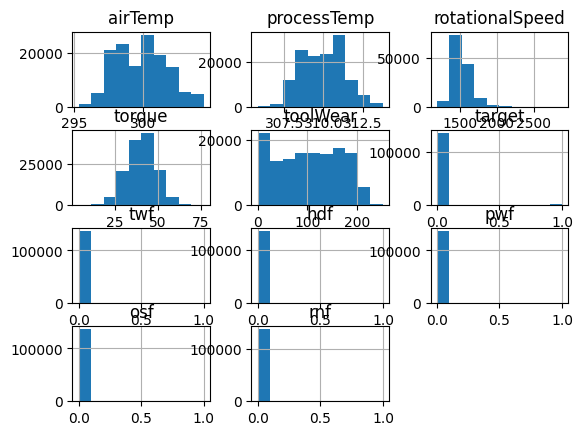

In [8]:
train_df.hist()

In [9]:
train_df['target'].value_counts()

target
0    134281
1      2148
Name: count, dtype: int64

In [10]:
num_cols = [col for col in train_df.columns if train_df[col].dtype != 'object']

<Axes: >

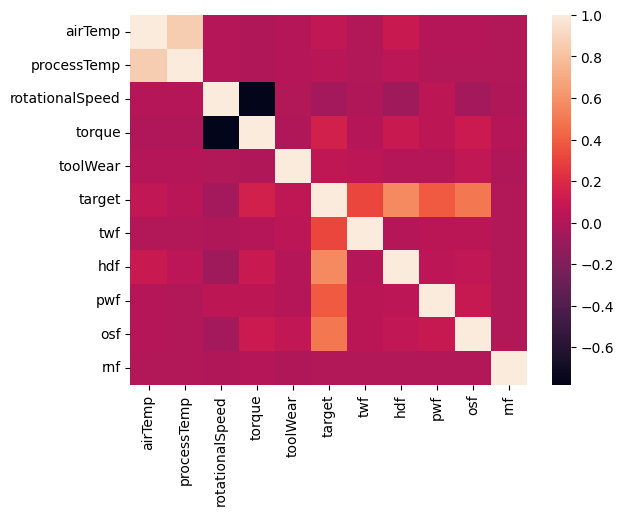

In [11]:
sns.heatmap(train_df[num_cols].corr())

In [12]:
new_feat = train_df['rotationalSpeed'] * train_df['airTemp'] / train_df['processTemp']
new_feat = pd.DataFrame(new_feat)
new_feat.corrwith(train_df['target'])

0   -0.05798
dtype: float64

In [13]:
y = train_df['target']
train_df.drop(['target'], axis=1, inplace=True)

In [14]:
train_df['productId'].value_counts()

productId
L53257    139
L49056    131
L53271    131
L54275    120
L48892    120
         ... 
M24614      1
H39399      1
M15853      1
H32637      1
L48036      1
Name: count, Length: 9976, dtype: int64

In [15]:
train_df.drop(['productId'], axis=1, inplace=True)

In [16]:
train_df = pd.concat(
    [
        train_df,
        pd.get_dummies(train_df["type"], prefix="type"),
    ],
    axis=1,
)

In [17]:
train_df.drop(['type'], axis=1, inplace=True)

In [18]:
train_df.head()

,airTemp,processTemp,rotationalSpeed,torque,toolWear,twf,hdf,pwf,osf,rnf,type_H,type_L,type_M
id,,,,,,,,,,,,,
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,False,True,False
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,False,False,True
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,False,True,False
3,301.0,310.9,1524,44.3,197,0,0,0,0,0,False,True,False
4,298.0,309.0,1641,35.4,34,0,0,0,0,0,False,False,True


In [19]:
train_df.columns

Index(['airTemp', 'processTemp', 'rotationalSpeed', 'torque', 'toolWear',
       'twf', 'hdf', 'pwf', 'osf', 'rnf', 'type_H', 'type_L', 'type_M'],
      dtype='object')

Feature ranking:
1. hdf 0.285913 
2. osf 0.208452 
3. pwf 0.109451 
4. torque 0.094671 
5. twf 0.087566 
6. rotationalSpeed 0.073545 
7. toolWear 0.055427 
8. airTemp 0.041284 
9. processTemp 0.038420 
10. type_L 0.002032 
11. type_M 0.001735 
12. type_H 0.001232 
13. rnf 0.000271 


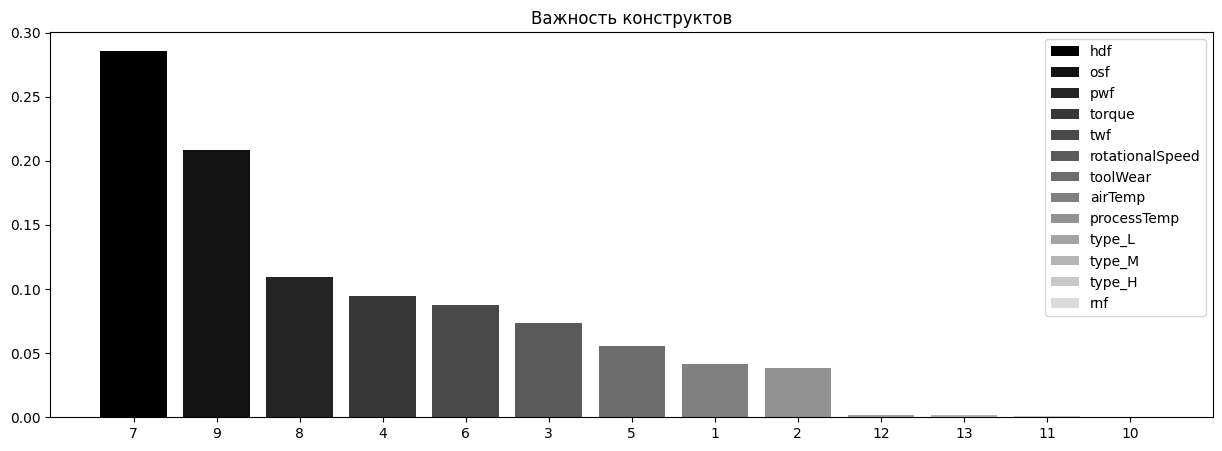

In [20]:
forest = RandomForestClassifier(random_state=17, n_estimators=50, max_features = 3)
forest.fit(train_df, y)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1] #индексы через которые можно отсортировать массив
num_to_plot = 13 #кол-ва фичей
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]
features = {
    "f1": u"airTemp",
    "f2": u"processTemp",
    "f3": u"rotationalSpeed",
    "f4": u"torque",
    "f5": u"toolWear",
    "f6": u"twf",
    "f7": u"hdf",
    "f8": u"pwf",
    "f9": u"osf",
    "f10": u"rnf",
    "f11": u"type_H",
    "f12": u"type_L",
    "f13": u"type_M"
}

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Важность конструктов")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

In [21]:
new_feat = train_df['rotationalSpeed'] / train_df['processTemp']
new_feat = pd.DataFrame(new_feat)
new_feat.corrwith(y)

0   -0.062255
dtype: float64

# Features Engine

In [22]:
train_df['power'] = train_df['torque'] * train_df['rotationalSpeed']
train_df['rotationalSpeed_TorqueRatio'] = train_df['rotationalSpeed'] / train_df['torque']
# Calculate temperature difference
train_df['temperatureDifference'] = train_df['processTemp'] - train_df['airTemp']
# Calculate temperature variability
train_df['temperatureVariability'] = train_df[['airTemp', 'processTemp']].std(axis=1)
# Calculate temperature ratio
train_df['temperatureRatio'] = train_df['processTemp'] / train_df['airTemp']

In [23]:
max_tool_wear = train_df['toolWear'].max()
train_df['toolWearRate'] = train_df['toolWear'] / max_tool_wear
# Calculate temperature change rate
train_df['temperatureChangeRate'] = train_df['temperatureDifference'] / (np.where(train_df['toolWear']==0, 2,train_df['toolWear']))

In [24]:
train_df['totalFailures'] = train_df[['twf', 'hdf', 'pwf', 'osf', 'rnf']].sum(axis=1)

In [25]:
train_df.head()

,airTemp,processTemp,rotationalSpeed,torque,toolWear,twf,hdf,pwf,osf,rnf,...,type_L,type_M,power,rotationalSpeed_TorqueRatio,temperatureDifference,temperatureVariability,temperatureRatio,toolWearRate,temperatureChangeRate,totalFailures
id,,,,,,,,,,,,,,,,,,,,,
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,...,True,False,57615.6,44.210526,9.0,6.363961,1.029940,0.553360,0.064286,0
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,...,False,True,51186.9,60.446735,9.5,6.717514,1.031395,0.790514,0.047500,0
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,...,True,False,47832.5,68.113208,9.2,6.505382,1.030738,0.098814,0.368000,0
3,301.0,310.9,1524,44.3,197,0,0,0,0,0,...,True,False,67513.2,34.401806,9.9,7.000357,1.032890,0.778656,0.050254,0
4,298.0,309.0,1641,35.4,34,0,0,0,0,0,...,False,True,58091.4,46.355932,11.0,7.778175,1.036913,0.134387,0.323529,0


<Axes: >

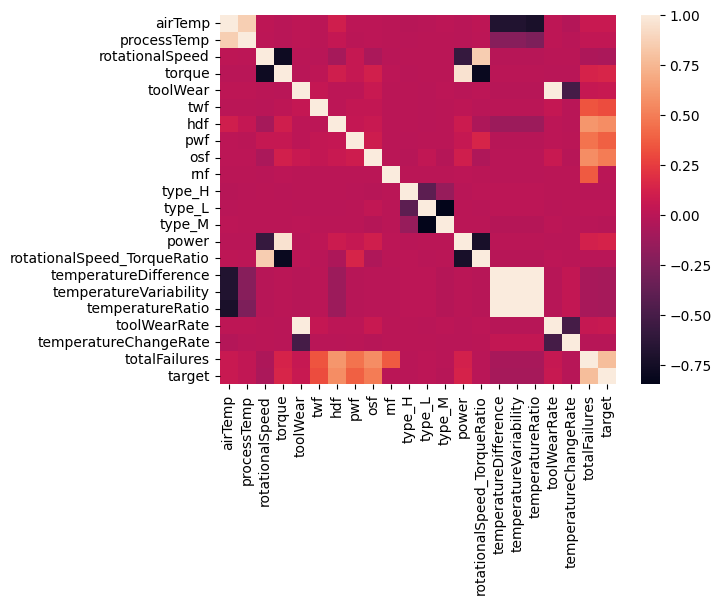

In [26]:
sns.heatmap(pd.concat([train_df, y], axis=1).corr())

In [27]:
train_df.columns

Index(['airTemp', 'processTemp', 'rotationalSpeed', 'torque', 'toolWear',
       'twf', 'hdf', 'pwf', 'osf', 'rnf', 'type_H', 'type_L', 'type_M',
       'power', 'rotationalSpeed_TorqueRatio', 'temperatureDifference',
       'temperatureVariability', 'temperatureRatio', 'toolWearRate',
       'temperatureChangeRate', 'totalFailures'],
      dtype='object')

Feature ranking:
1. totalFailures 0.325095 
2. hdf 0.107099 
3. osf 0.090257 
4. pwf 0.053798 
5. rotationalSpeed 0.047384 
6. rotationalSpeed_TorqueRatio 0.045844 
7. twf 0.043417 
8. power 0.040821 
9. torque 0.040675 
10. temperatureRatio 0.029814 
11. rnf 0.028259 
12. temperatureChangeRate 0.024672 
13. toolWearRate 0.024346 
14. toolWear 0.023783 
15. temperatureVariability 0.020485 
16. airTemp 0.017434 
17. processTemp 0.016270 
18. temperatureDifference 0.014481 
19. type_L 0.002514 
20. type_M 0.002275 
21. type_H 0.001277 


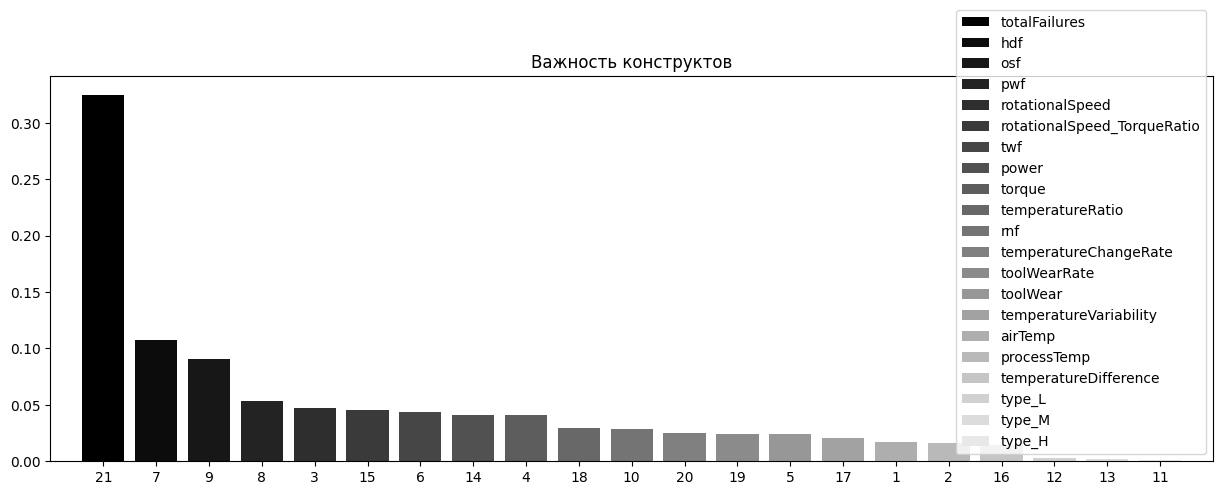

In [28]:

forest.fit(train_df, y)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1] #индексы через которые можно отсортировать массив
num_to_plot = 21 #кол-ва фичей
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]
features = {
    "f1": u"airTemp",
    "f2": u"processTemp",
    "f3": u"rotationalSpeed",
    "f4": u"torque",
    "f5": u"toolWear",
    "f6": u"twf",
    "f7": u"hdf",
    "f8": u"pwf",
    "f9": u"osf",
    "f10": u"rnf",
    "f11": u"type_H",
    "f12": u"type_L",
    "f13": u"type_M",
    'f14': u'power',
    'f15': u'rotationalSpeed_TorqueRatio',
    'f16': u'temperatureDifference',
    'f17': u'temperatureVariability',
    'f18': u'temperatureRatio',
    'f19': u'toolWearRate',
    'f20': u'temperatureChangeRate',
    'f21': u'totalFailures'
}

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Важность конструктов")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

# 2 models XGB and RF

In [29]:
train_df.head()

,airTemp,processTemp,rotationalSpeed,torque,toolWear,twf,hdf,pwf,osf,rnf,...,type_L,type_M,power,rotationalSpeed_TorqueRatio,temperatureDifference,temperatureVariability,temperatureRatio,toolWearRate,temperatureChangeRate,totalFailures
id,,,,,,,,,,,,,,,,,,,,,
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,...,True,False,57615.6,44.210526,9.0,6.363961,1.029940,0.553360,0.064286,0
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,...,False,True,51186.9,60.446735,9.5,6.717514,1.031395,0.790514,0.047500,0
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,...,True,False,47832.5,68.113208,9.2,6.505382,1.030738,0.098814,0.368000,0
3,301.0,310.9,1524,44.3,197,0,0,0,0,0,...,True,False,67513.2,34.401806,9.9,7.000357,1.032890,0.778656,0.050254,0
4,298.0,309.0,1641,35.4,34,0,0,0,0,0,...,False,True,58091.4,46.355932,11.0,7.778175,1.036913,0.134387,0.323529,0


# prepare test df

In [30]:
df = pd.read_csv('./test.csv', index_col='id')

In [31]:
df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,
136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [32]:
name = dict(
    zip(df.columns,
       [
           'productId',
           'type',
           'airTemp',
           'processTemp',
           'rotationalSpeed',
           'torque',
           'toolWear',
           'twf',
           'hdf',
           'pwf',
           'osf',
           'rnf'
       ])
)

In [33]:
df.rename(columns=name, inplace=True)

In [34]:
df.drop(['productId'], axis=1, inplace=True)

In [35]:
df = pd.concat(
    [
        df,
        pd.get_dummies(df["type"], prefix="type"),
    ],
    axis=1,
)

In [36]:
df['power'] = df['torque'] * df['rotationalSpeed']
df['rotationalSpeed_TorqueRatio'] = df['rotationalSpeed'] / df['torque']
# Calculate temperature difference
df['temperatureDifference'] = df['processTemp'] - df['airTemp']
# Calculate temperature variability
df['temperatureVariability'] = df[['airTemp', 'processTemp']].std(axis=1)
# Calculate temperature ratio
df['temperatureRatio'] = df['processTemp'] / df['airTemp']
max_tool_wear = df['toolWear'].max()
df['toolWearRate'] = df['toolWear'] / max_tool_wear
# Calculate temperature change rate
df['temperatureChangeRate'] = df['temperatureDifference'] / (np.where(df['toolWear']==0, 2,df['toolWear']))
df['totalFailures'] = df[['twf', 'hdf', 'pwf', 'osf', 'rnf']].sum(axis=1)

In [37]:
df.drop(['type'], axis=1, inplace=True)

# Train model

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y,
                                                               train_size=0.8,
                                                               test_size=0.2,
                                                               random_state=0)


In [39]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [40]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 180, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [41]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 3
)

In [42]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 180, 40)},
             scoring='roc_auc')

In [44]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=140, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [46]:
xgb = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None,  monotone_constraints=None,
              n_estimators=140, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None)

In [48]:
pred = xgb.fit(X_train, y_train)

In [49]:
y_pred = xgb.predict_proba(X_valid)

In [51]:
roc_auc_score(y_valid, y_pred[:,1])

0.9689853340669166

In [52]:
final_predict = xgb.predict_proba(df)

In [53]:
final_predict.shape

(90954, 2)

In [88]:
final_predict.shape[0]

90954

In [96]:
np.arange(0,90955)

array([    0,     1,     2, ..., 90952, 90953, 90954])

In [101]:
def write_to_submission_file(predicted_labels, out_file,
                             target='Machine failure', index_label="id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, 
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [102]:
write_to_submission_file(final_predict[:,1], 'output.csv')

In [92]:
out = pd.read_csv('./output.csv', index_col='id')

In [93]:
out[:-1]

,Machine failure
id,
0,0.001345
1,0.001778
2,0.000828
3,0.001229
4,0.001159
...,...
90948,0.000692
90949,0.001461
90950,0.000817


In [104]:
output = pd.DataFrame({'id': df.index, 'Machine failure': final_predict[:,1]})
output.to_csv('submission.csv', index=False)

In [106]:
output.head()

,id,Machine failure
0,136429,0.001345
1,136430,0.001778
2,136431,0.000828
3,136432,0.001229
4,136433,0.001159


# Tune model Training on all data 

In [ ]:
orig = pd.read_csv('./machine failure.csv')
train = pd